# Testing Normal Distribution Assumption

In [1]:
from koopman_probabilistic import *
import vanilla_benchmark

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew

## Pinball Loss

In [2]:
def normal_pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = norm.ppf(q, loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [3]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [4]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

## Vanilla Benchmark Forecast

In [5]:
min_train_start = 9 * 365 * 24 + 2 * 24  # 2 leap years in from 2005 to 2014
train_starts = np.linspace(min_train_start, min_train_start + 24 * 365 - 24, 12, endpoint=False).astype(int)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [6]:
print(list(train_starts))

[78888, 79616, 80344, 81072, 81800, 82528, 83256, 83984, 84712, 85440, 86168, 86896]


In [7]:
zone_name = "ISONE CA"

In [8]:
vanilla_losses = [356.65285345770917, 481.60001293416417, 306.9847366241878, 300.8401201239931, 456.5542981969828, 424.49642594094337, 602.1345034614963, 693.6073318641133, 638.0186776975577, 284.1337486215403, 361.2858309902031, 492.39473862092865]
# vanilla_losses = []
# for train_start in train_starts:
#     vanilla_losses.append(vanilla_benchmark.get_lossesGEFCom(start=train_start, zones=[zone_name], plot=True)[zone_name])

In [9]:
for loss in vanilla_losses:
    print(np.round(loss, 1), end="\t")

356.7	481.6	307.0	300.8	456.6	424.5	602.1	693.6	638.0	284.1	361.3	492.4	

In [10]:
import json

with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))

In [11]:
# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

data (96408, 1)


# Forecasting mean and variance of Gaussian

In [ ]:
%matplotlib inline
mu_hats = []
sigma_hats = []
z_scores_list = []
test_z_scores_list = []
losses = []
relative_perf = []

for month, train_start in list(enumerate(train_starts))[:1]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPnormality_" + f"_train_start={train_start}_" + now

    num_freqs = [4, 4]
    num_fourier = 4
    mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
    sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
    print("x", x.shape)
    print("xt", xt.shape)
    
    
    ### TRAIN ###
    model = AlternatingNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=128)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])
    
    k.fit(xt, iterations=200, interval=10, verbose=True, cutoff=0, weight_decay=1e-10000, lr_theta=1e-4, lr_omega=0, num_slices=None);
#     k.fit(xt, iterations=1000, interval=10, verbose=False, cutoff=0, weight_decay=1e-10000, lr_theta=1e-5, lr_omega=0, num_slices=None);
    
    
    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hats.append(params[0])
    sigma_hats.append(params[1])
    np.save(mu_file, mu_hats[-1])
    np.save(sigma_file, sigma_hats[-1])
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()
    
    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))
    
    z_scores_list.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores_list.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    
    ### PERFORMANCE ###
    test_start = train_through + delay

    # Normal Distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    sigh = sigma_hats[-1][test_start: predict_through] * rnge
    muh = mu_hats[-1][test_start: predict_through] * rnge + mean
    mean_hat = model.mean([muh, sigh])
    std_hat = model.std([muh, sigh])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()
    
    loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perf.append(relative)
    
%matplotlib notebook

# Forecasting mean, variance, and skewness of Skew-Normal distribution

TRAIN START: 78888 = 2014-01-01 00:00:00
x (9504, 1)
xt (8760, 1)
Iteration  0
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.04764498630282908
Iteration  1
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.041934686694469786
Iteration  2
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.00

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.01651267713780274
Iteration  22
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.016328154021129557
Iteration  23
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.0161646532317

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.014962187026560589
Iteration  44
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.014946819171168888
Iteration  45
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.014933015759

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.014821917701717643
Iteration  66
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.01482014231272297
Iteration  67
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.0148185084118

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.014800965720227344
Iteration  88
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.01480044971419399
Iteration  89
tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8766.0000,   24.0000,  168.0000,
         730.4999, 8766.0000,   24.0000,  168.0000,  730.4999, 8766.0000],
       grad_fn=<MulBackward0>)
Loss:  0.0147999465452

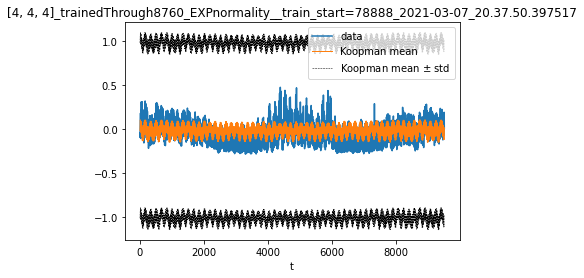

actual overall mean: 0  predicted mean: -0.01763517


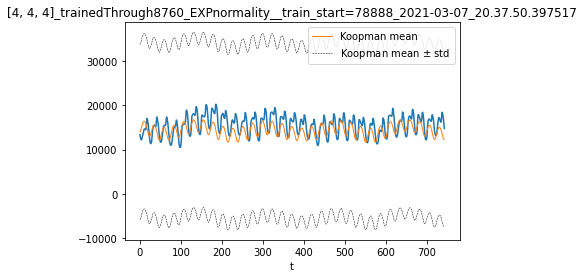

pinball_loss: 2547.071006400369
-614.1597162918515% performance relative to vanilla benchmark







In [12]:
%matplotlib inline
mu_hats = []
sigma_hats = []
z_scores_list = []
test_z_scores_list = []
losses = []
relative_perf = []

for month, train_start in list(enumerate(train_starts))[:1]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPnormality_" + f"_train_start={train_start}_" + now

    
    num_freqs = [4, 4, 4]
    num_fourier = 4
    mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
    sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
    alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
    print("x", x.shape)
    print("xt", xt.shape)
    
    
    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=128)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])
    
    k.fit(xt, iterations=100, interval=10, verbose=True, cutoff=0, weight_decay=1e-10000, lr_theta=1e-4, lr_omega=0, num_slices=None);
#     k.fit(xt, iterations=300, interval=10, verbose=False, cutoff=0, weight_decay=1e-10000, lr_theta=1e-5, lr_omega=0, num_slices=None);
    
    
    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()
    
    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))
    
    z_scores_list.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores_list.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    
    ### PERFORMANCE ###
    
    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()
    
    loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perf.append(relative)
    
%matplotlib notebook

# Figures

In [ ]:
# for tables
for loss in losses:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perf:
    print(np.round(rel, 1), end="%\t")

In [ ]:
%matplotlib inline
plt.subplots(dpi=150, figsize=(6, 8))
for month, z_scores in enumerate(z_scores_list):
    z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
    print(f"mean of z-scores in month {months[month]}:", np.mean(z_scores), "std of z-scores:", np.std(z_scores))
    
    plt.subplot(4, 3, month + 1)
    plt.plot(z_axis, z_hist, label="Koopman z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(months[month])
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
plt.subplots(dpi=150, figsize=(6, 8))
for month, z_scores in enumerate(test_z_scores_list):
    z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
    print(f"mean of z-scores in month {month}:", np.mean(z_scores), "std of z-scores:", np.std(z_scores))
    
    plt.subplot(4, 3, month + 1)
    plt.plot(z_axis, z_hist, label="Koopman test z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(str(month + 1))
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

In [ ]:
for z_scores in z_scores_list:
    print(np.round(np.mean(z_scores), 2), end="\t")
print()
for z_scores in z_scores_list:
    print(np.round(np.std(z_scores), 2), end="\t")
print()
for z_scores in z_scores_list:
    print(np.round(skew(z_scores)[0], 2), end="\t")
print()
for z_scores in test_z_scores_list:
    print(np.round(np.mean(z_scores), 2), end="\t")
print()
for z_scores in test_z_scores_list:
    print(np.round(np.std(z_scores), 2), end="\t")
print()
for z_scores in test_z_scores_list:
    print(np.round(skew(z_scores)[0], 2), end="\t")

In [ ]:
k.fit(xt, iterations=200, interval=10, verbose=False, cutoff=0, weight_decay=1e-10000, lr_theta=1e-5, lr_omega=0, num_slices=None);